In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Resnet-34

In [3]:
def _gen_l2_regularizer(use_l2_regularizer=True):
    return keras.regularizers.l2(1e-5) if use_l2_regularizer else None

In [4]:
def conv_block_34(input_layer,channel, stage, block_num, not_plane=True, use_l2_regularizer=True):
    
    BATCH_NORM_DECAY = 0.9
    BATCH_NORM_EPSILON = 1e-5
    
    bn_axis = 3 if keras.backend.image_data_format() == 'channels_last' else 1
    
    x = input_layer
    
    x = keras.layers.Conv2D(
        filters=channel,
        kernel_size=(3,3),
        padding='same',
        kernel_initializer=keras.initializers.he_normal,
        kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
        name= 'stage' + str(stage) + '_' + str(block_num) + '_conv1'
    )(x)
    
    x = keras.layers.BatchNormalization(
        axis=bn_axis,
        momentum=BATCH_NORM_DECAY,
        epsilon=BATCH_NORM_EPSILON,
        name = 'stage' + str(stage) + '_' + str(block_num) + '_bn1'
    )(x)
    
    x = keras.layers.Activation('relu')(x)
    
    
    x = keras.layers.Conv2D(
        filters=channel,
        kernel_size=(3,3),
        padding='same',
        kernel_initializer=keras.initializers.he_normal,
        kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
        name= 'stage' + str(stage) + '_' + str(block_num) + '_conv2'
    )(x)
    
    x = keras.layers.BatchNormalization(
        axis=bn_axis,
        momentum=BATCH_NORM_DECAY,
        epsilon=BATCH_NORM_EPSILON,
        name = 'stage' + str(stage) + '_' + str(block_num) + '_bn2'
    )(x)
    
    if not_plane:
        x = keras.layers.add([x, input_layer], name = 'stage' + str(stage) + '_' + str(block_num) + '_add')  # identity mapping
    x = keras.layers.Activation('relu')(x)
    
    return x

## Block하나 확인

In [5]:
input_layer = keras.layers.Input(shape=(8,8,64)) 

test_block = conv_block_34(input_layer,64, 2, 1)

model = keras.Model(inputs=input_layer, outputs=test_block)  

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8, 8, 64)]   0                                            
__________________________________________________________________________________________________
stage2_1_conv1 (Conv2D)         (None, 8, 8, 64)     36928       input_1[0][0]                    
__________________________________________________________________________________________________
stage2_1_bn1 (BatchNormalizatio (None, 8, 8, 64)     256         stage2_1_conv1[0][0]             
__________________________________________________________________________________________________
activation (Activation)         (None, 8, 8, 64)     0           stage2_1_bn1[0][0]               
______________________________________________________________________________________________

In [6]:
def stride_conv_block_34(input_layer,channel, stage, block_num, not_plane=True, use_l2_regularizer=True):
    
    BATCH_NORM_DECAY = 0.9
    BATCH_NORM_EPSILON = 1e-5
    
    bn_axis = 3 if keras.backend.image_data_format() == 'channels_last' else 1
    
    x = input_layer
    
    x = keras.layers.Conv2D(
        filters=channel,
        kernel_size=(3,3),
        strides=2,
        padding='same',
        kernel_initializer=keras.initializers.he_normal,
        kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
        name= 'stage' + str(stage) + '_' + str(block_num) + '_conv1'
    )(x)
    
    x = keras.layers.BatchNormalization(
        axis=bn_axis,
        momentum=BATCH_NORM_DECAY,
        epsilon=BATCH_NORM_EPSILON,
        name = 'stage' + str(stage) + '_' + str(block_num) + '_bn1'
    )(x)
    
    x = keras.layers.Activation('relu')(x)
    
    
    x = keras.layers.Conv2D(
        filters=channel,
        kernel_size=(3,3),
        padding='same',
        kernel_initializer=keras.initializers.he_normal,
        kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
        name= 'stage' + str(stage) + '_' + str(block_num) + '_conv2'
    )(x)
    
    x = keras.layers.BatchNormalization(
        axis=bn_axis,
        momentum=BATCH_NORM_DECAY,
        epsilon=BATCH_NORM_EPSILON,
        name = 'stage' + str(stage) + '_' + str(block_num) + '_bn2'
    )(x)
    
    
    
    shortcut_proj = keras.layers.Conv2D(
        filters=channel,
        kernel_size=(3,3),
        strides=2,
        padding='same',
        kernel_initializer=keras.initializers.he_normal,
        kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
        name= 'stage' + str(stage) + '_' + str(block_num) + '_shortcut'
    )(input_layer)
    shortcut_proj = keras.layers.BatchNormalization(
        axis=bn_axis,
        momentum=BATCH_NORM_DECAY,
        epsilon=BATCH_NORM_EPSILON,
        name = 'stage' + str(stage) + '_' + str(block_num) + '_shortcut_bn'
    )(shortcut_proj)
    
    if not_plane:
        x = keras.layers.add([x, shortcut_proj], name = 'stage' + str(stage) + '_' + str(block_num) + 'add')  # identity mapping
    x = keras.layers.Activation('relu')(x)
    
    return x

In [7]:
def stage1(input_layer, use_l2_regularizer=True):
    
    L2_WEIGHT_DECAY = 1e-5
    BATCH_NORM_DECAY = 0.9
    BATCH_NORM_EPSILON = 1e-5
    
    bn_axis = 3 if keras.backend.image_data_format() == 'channels_last' else 1
    
    input_img = input_layer
    
    x = keras.layers.ZeroPadding2D(padding=3)(input_img)
    
    x = keras.layers.Conv2D(
        filters=64,
        kernel_size=(7,7),
        strides=2,
        padding='same',
        kernel_initializer=keras.initializers.he_normal,
        kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
        name= 'stage1_conv2d'
    )(input_img)
    
    x = keras.layers.BatchNormalization(
        axis=bn_axis,
        momentum=BATCH_NORM_DECAY,
        epsilon=BATCH_NORM_EPSILON,
        name = 'stage1_BN'
    )(x)
    
    x = keras.layers.Activation('relu')(x)
    
    #x = keras.layers.ZeroPadding2D(padding=1)(x)
    x = keras.layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)
    
    return x

In [8]:
def build_resnet34(input_shape=(32,32,3), channel=[64,128,256,512], block_num=[3,4,6,3], not_plane=True, num_classes=10, use_l2_regularizer=True):
    
    L2_WEIGHT_DECAY = 1e-5
    BATCH_NORM_DECAY = 0.9
    BATCH_NORM_EPSILON = 1e-5
    
    input_layer = keras.layers.Input(shape=input_shape) 
    
    stage1_output = stage1(input_layer, use_l2_regularizer=use_l2_regularizer)
    
    x = stage1_output
    
    for i in range(len(channel)):
        #print('stage:',i+2)
        if i == 0 :
            x = conv_block_34(x,channel[i], i+2, 1, not_plane, use_l2_regularizer=use_l2_regularizer)
        else :
            x = stride_conv_block_34(x,channel[i], i+2, 1, not_plane, use_l2_regularizer=use_l2_regularizer)
        for j in range(2,block_num[i]+1):
            #print('block:',j)
            x = conv_block_34(x,channel[i], i+2, j,not_plane, use_l2_regularizer=use_l2_regularizer)
    
    x = keras.layers.AveragePooling2D((1,1), name='average_pool')(x)
    x = keras.layers.Flatten(name='flatten')(x)
    
    output = keras.layers.Dense(
        num_classes,
        kernel_initializer=keras.initializers.RandomNormal(stddev=0.01),
        kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
        bias_regularizer=_gen_l2_regularizer(use_l2_regularizer),
        name='fc1000')(x)
    
    '''output = keras.layers.Dense(
        num_classes,
        name='fc1000')(x)'''
    
    output = keras.layers.Activation('softmax', dtype='float32')(output)
    
    model = keras.Model(inputs=input_layer, outputs=output)  
    
    return model

In [9]:
model34 = build_resnet34()

model34.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
stage1_conv2d (Conv2D)          (None, 16, 16, 64)   9472        input_2[0][0]                    
__________________________________________________________________________________________________
stage1_BN (BatchNormalization)  (None, 16, 16, 64)   256         stage1_conv2d[0][0]              
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 16, 16, 64)   0           stage1_BN[0][0]                  
____________________________________________________________________________________________

# Resnet-50

In [10]:
def conv_block_50(input_layer,channel, stage, block_num, not_plane=True, use_l2_regularizer=True):
    
    BATCH_NORM_DECAY = 0.9
    BATCH_NORM_EPSILON = 1e-5
    
    bn_axis = 3 if keras.backend.image_data_format() == 'channels_last' else 1
    
    x = input_layer
    
    x = keras.layers.Conv2D(
        filters=channel,
        kernel_size=(1,1),
        kernel_initializer=keras.initializers.he_normal,
        kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
        name= 'stage' + str(stage) + '_' + str(block_num) + '_conv1'
    )(x)
    
    x = keras.layers.BatchNormalization(
        axis=bn_axis,
        momentum=BATCH_NORM_DECAY,
        epsilon=BATCH_NORM_EPSILON,
        name = 'stage' + str(stage) + '_' + str(block_num) + '_bn1'
    )(x)
    
    x = keras.layers.Activation('relu')(x)
    
    x = keras.layers.Conv2D(
        filters=channel,
        kernel_size=(3,3),
        padding='same',
        kernel_initializer=keras.initializers.he_normal,
        kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
        name= 'stage' + str(stage) + '_' + str(block_num) + '_conv2'
    )(x)
    
    x = keras.layers.BatchNormalization(
        axis=bn_axis,
        momentum=BATCH_NORM_DECAY,
        epsilon=BATCH_NORM_EPSILON,
        name = 'stage' + str(stage) + '_' + str(block_num) + '_bn2'
    )(x)
    
    x = keras.layers.Activation('relu')(x)
    
    
    x = keras.layers.Conv2D(
        filters=channel*4,
        kernel_size=(1,1),
        kernel_initializer=keras.initializers.he_normal,
        kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
        name= 'stage' + str(stage) + '_' + str(block_num) + '_conv3'
    )(x)
    
    x = keras.layers.BatchNormalization(
        axis=bn_axis,
        momentum=BATCH_NORM_DECAY,
        epsilon=BATCH_NORM_EPSILON,
        name = 'stage' + str(stage) + '_' + str(block_num) + '_bn3'
    )(x)
   
    
    if not_plane:
        x = keras.layers.add([x, input_layer], name = 'stage' + str(stage) + '_' + str(block_num) + '_add')  # identity mapping
    x = keras.layers.Activation('relu')(x)
    
    return x

In [11]:
def stride_conv_block_50(input_layer,channel, stage, block_num, not_plane, stride = 2, use_l2_regularizer=True):
    
    BATCH_NORM_DECAY = 0.9
    BATCH_NORM_EPSILON = 1e-5
    
    bn_axis = 3 if keras.backend.image_data_format() == 'channels_last' else 1
    
    x = input_layer
    
    x = keras.layers.Conv2D(
        filters=channel,
        kernel_size=(1,1),
        strides=stride,
        kernel_initializer=keras.initializers.he_normal,
        kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
        name= 'stage' + str(stage) + '_' + str(block_num) + '_conv1'
    )(x)
    
    x = keras.layers.BatchNormalization(
        axis=bn_axis,
        momentum=BATCH_NORM_DECAY,
        epsilon=BATCH_NORM_EPSILON,
        name = 'stage' + str(stage) + '_' + str(block_num) + '_bn1'
    )(x)
    
    x = keras.layers.Activation('relu')(x)
    
    x = keras.layers.Conv2D(
        filters=channel,
        kernel_size=(3,3),
        padding='same',
        kernel_initializer=keras.initializers.he_normal,
        kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
        name= 'stage' + str(stage) + '_' + str(block_num) + '_conv2'
    )(x)
    
    x = keras.layers.BatchNormalization(
        axis=bn_axis,
        momentum=BATCH_NORM_DECAY,
        epsilon=BATCH_NORM_EPSILON,
        name = 'stage' + str(stage) + '_' + str(block_num) + '_bn2'
    )(x)
    
    x = keras.layers.Activation('relu')(x)
    
    
    x = keras.layers.Conv2D(
        filters=channel*4,
        kernel_size=(1,1),
        kernel_initializer=keras.initializers.he_normal,
        kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
        name= 'stage' + str(stage) + '_' + str(block_num) + '_conv3'
    )(x)
    
    x = keras.layers.BatchNormalization(
        axis=bn_axis,
        momentum=BATCH_NORM_DECAY,
        epsilon=BATCH_NORM_EPSILON,
        name = 'stage' + str(stage) + '_' + str(block_num) + '_bn3'
    )(x)
    
    
    
    shortcut = keras.layers.Conv2D(
        filters=channel*4,
        kernel_size=(1,1),
        strides=stride,
        kernel_initializer=keras.initializers.he_normal,
        kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
        name= 'stage' + str(stage) + '_' + str(block_num) + '_shortcut'
    )(input_layer)
    shortcut = keras.layers.BatchNormalization(
        axis=bn_axis,
        momentum=BATCH_NORM_DECAY,
        epsilon=BATCH_NORM_EPSILON,
        name = 'stage' + str(stage) + '_' + str(block_num) + '_shortcut_bn'
    )(shortcut)
    
    if not_plane:
        x = keras.layers.add([x, shortcut], name = 'stage' + str(stage) + '_' + str(block_num) + 'add')  # identity mapping
    x = keras.layers.Activation('relu')(x)
    
    return x

In [12]:
def build_resnet50(input_shape=(32,32,3), channel=[64,128,256,512], block_num=[3,4,6,3], not_plane=True, num_classes=10, use_l2_regularizer=True):
    
    L2_WEIGHT_DECAY = 1e-5
    BATCH_NORM_DECAY = 0.9
    BATCH_NORM_EPSILON = 1e-5
    
    input_layer = keras.layers.Input(shape=input_shape) 
    
    stage1_output = stage1(input_layer)
    
    x = stage1_output
    
    for i in range(len(channel)):
        #print('stage:',i+2)
        if i == 0 :
            x = stride_conv_block_50(x,channel[i], i+2, 1, not_plane, stride=1, use_l2_regularizer=use_l2_regularizer)
        else :
            x = stride_conv_block_50(x,channel[i], i+2, 1, not_plane, use_l2_regularizer=use_l2_regularizer)
        #x = stride_conv_block_50(x,channel[i], i+2, 1, not_plane)
        for j in range(2,block_num[i]+1):
            #print('block:',j)
            x = conv_block_50(x,channel[i], i+2, j, not_plane, use_l2_regularizer=use_l2_regularizer)
    
    x = keras.layers.AveragePooling2D((1,1), name='average_pool')(x)
    x = keras.layers.Flatten(name='flatten')(x)
    output = keras.layers.Dense(
        num_classes,
        kernel_initializer=keras.initializers.RandomNormal(stddev=0.01),
        kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
        bias_regularizer=_gen_l2_regularizer(use_l2_regularizer),
        name='fc1000')(x)
    '''output = keras.layers.Dense(
        num_classes,
        name='fc1000')(x)'''
    output = keras.layers.Activation('softmax', dtype='float32')(output)
    
    model = keras.Model(inputs=input_layer, outputs=output)  
    
    return model

In [13]:
model50 = build_resnet50()

model50.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
stage1_conv2d (Conv2D)          (None, 16, 16, 64)   9472        input_3[0][0]                    
__________________________________________________________________________________________________
stage1_BN (BatchNormalization)  (None, 16, 16, 64)   256         stage1_conv2d[0][0]              
__________________________________________________________________________________________________
activation_36 (Activation)      (None, 16, 16, 64)   0           stage1_BN[0][0]                  
____________________________________________________________________________________________

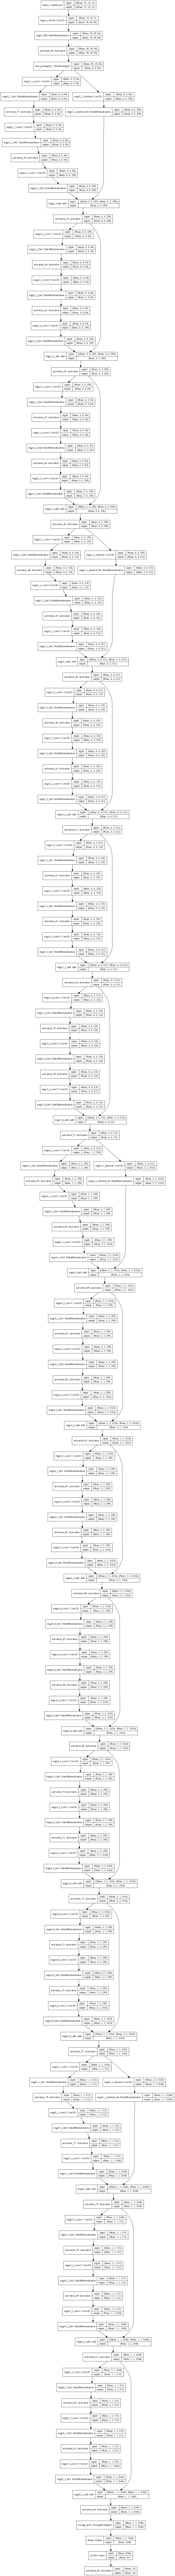

In [14]:
tf.keras.utils.plot_model(model50, show_shapes=True, dpi=64)

# Plane-34 / Plane-50

In [15]:
model_plane_34 = build_resnet34(not_plane=False)

model_plane_34.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
stage1_conv2d (Conv2D)       (None, 16, 16, 64)        9472      
_________________________________________________________________
stage1_BN (BatchNormalizatio (None, 16, 16, 64)        256       
_________________________________________________________________
activation_86 (Activation)   (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
stage2_1_conv1 (Conv2D)      (None, 8, 8, 64)          36928     
_________________________________________________________________
stage2_1_bn1 (BatchNormaliza (None, 8, 8, 64)          256 

In [16]:
model_plane_50 = build_resnet50(not_plane=False)

model_plane_50.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
stage1_conv2d (Conv2D)       (None, 16, 16, 64)        9472      
_________________________________________________________________
stage1_BN (BatchNormalizatio (None, 16, 16, 64)        256       
_________________________________________________________________
activation_120 (Activation)  (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
stage2_1_conv1 (Conv2D)      (None, 8, 8, 64)          4160      
_________________________________________________________________
stage2_1_bn1 (BatchNormaliza (None, 8, 8, 64)          256 

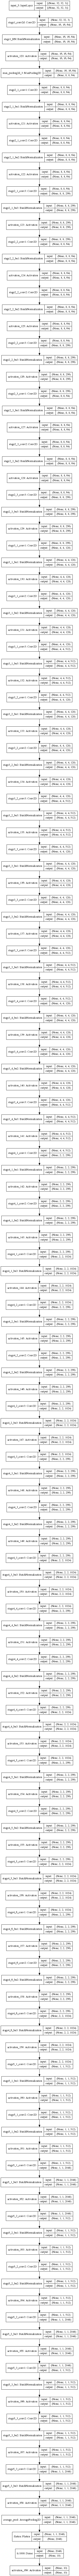

In [17]:
tf.keras.utils.plot_model(model_plane_50, show_shapes=True, dpi=64)

# cat_vs_dogs dataset

In [18]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

ds_train, train_info = tfds.load('cats_vs_dogs', split='train[:80%]', as_supervised=True,with_info=True,)
ds_test, test_info= tfds.load('cats_vs_dogs', split='train[-20%:]', as_supervised=True,with_info=True)

In [19]:
train_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})

In [20]:
train_info.features["label"].names

['cat', 'dog']

In [21]:
train_info.features["label"].num_classes

2

In [22]:
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


In [23]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [24]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [25]:
BATCH_SIZE = 32
EPOCH = 20

In [26]:
ds_train_batch = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test_batch = apply_normalize_on_dataset(ds_test, True, batch_size=BATCH_SIZE)

In [27]:
print(tf.data.experimental.cardinality(ds_train_batch))  # batch에넣으면 cardinality 안나오나??

tf.Tensor(-1, shape=(), dtype=int64)


In [28]:
print(ds_train)

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


In [29]:
cnd_model_plain_34 = build_resnet34(input_shape=(224,224,3), not_plane=False, num_classes=2)
cnd_model_plain_34.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
stage1_conv2d (Conv2D)       (None, 112, 112, 64)      9472      
_________________________________________________________________
stage1_BN (BatchNormalizatio (None, 112, 112, 64)      256       
_________________________________________________________________
activation_170 (Activation)  (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
stage2_1_conv1 (Conv2D)      (None, 56, 56, 64)        36928     
_________________________________________________________________
stage2_1_bn1 (BatchNormaliza (None, 56, 56, 64)        256 

In [30]:
cnd_model_plain_50 = build_resnet50(input_shape=(224,224,3), not_plane=False, num_classes=2)
cnd_model_plain_50.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
stage1_conv2d (Conv2D)       (None, 112, 112, 64)      9472      
_________________________________________________________________
stage1_BN (BatchNormalizatio (None, 112, 112, 64)      256       
_________________________________________________________________
activation_204 (Activation)  (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
stage2_1_conv1 (Conv2D)      (None, 56, 56, 64)        4160      
_________________________________________________________________
stage2_1_bn1 (BatchNormaliza (None, 56, 56, 64)        256 

# training on cats_vs_dogs

- 논문 구현환경과 비슷한 학습 세팅
  
  - input size : 224 x 224
  - optimizer : SGD
  - learining rate : 1e-2
  - learining rate schedule : 미사용
  - batch size : 32
  - decay : 1e-4
  - momentum : 0.9
  - epochs : 20

## Resnet-34 (l2_regularizer 미사용)

In [31]:
cnd_model34 = build_resnet34(input_shape=(224,224,3), num_classes=2, use_l2_regularizer=False)
cnd_model34.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stage1_conv2d (Conv2D)          (None, 112, 112, 64) 9472        input_8[0][0]                    
__________________________________________________________________________________________________
stage1_BN (BatchNormalization)  (None, 112, 112, 64) 256         stage1_conv2d[0][0]              
__________________________________________________________________________________________________
activation_254 (Activation)     (None, 112, 112, 64) 0           stage1_BN[0][0]                  
____________________________________________________________________________________________

In [32]:
'''cnd_model34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)),
    metrics=['accuracy'],
)'''

'''cnd_model34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)'''


cnd_model34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.0001, nesterov=False),
    metrics=['accuracy'],
)


'''cnd_model34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2),
    metrics=['accuracy'],
)'''



history_34 = cnd_model34.fit(
    ds_train_batch,
    steps_per_epoch=int(18610/BATCH_SIZE),
    validation_steps=int(4652/BATCH_SIZE),
    epochs=20,
    validation_data=ds_test_batch,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
581/581 [==============================] - 97s 140ms/step - loss: 10.8773 - accuracy: 0.5154 - val_loss: 0.7193 - val_accuracy: 0.5274
Epoch 2/20
581/581 [==============================] - 90s 155ms/step - loss: 0.7017 - accuracy: 0.5611 - val_loss: 0.6776 - val_accuracy: 0.5769
Epoch 3/20
581/581 [==============================] - 82s 140ms/step - loss: 0.6727 - accuracy: 0.5866 - val_loss: 0.6684 - val_accuracy: 0.6071
Epoch 4/20
581/581 [==============================] - 82s 140ms/step - loss: 0.6614 - accuracy: 0.6087 - val_loss: 0.6579 - val_accuracy: 0.6207
Epoch 5/20
581/581 [==============================] - 82s 141ms/step - loss: 0.6520 - accuracy: 0.6166 - val_loss: 0.6541 - val_accuracy: 0.6177
Epoch 6/20
581/581 [==============================] - 82s 141ms/step - loss: 0.6403 - accuracy: 0.6338 - val_loss: 0.6458 - val_accuracy: 0.6330
Epoch 7/20
581/581 [==============================] - 82s 141ms/step - loss: 0.6312 - accuracy: 0.6453 - val_loss: 0.6409 - val_a

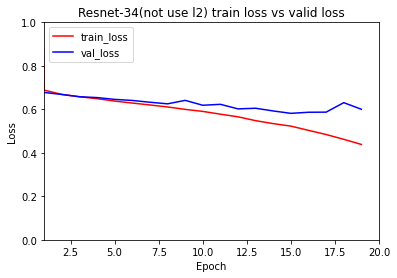

In [33]:
import matplotlib.pyplot as plt

plt.plot(history_34.history['loss'], 'r')
plt.plot(history_34.history['val_loss'], 'b')
plt.title('Resnet-34(not use l2) train loss vs valid loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train_loss', 'val_loss'], loc='upper left')
plt.xlim(1,20)
plt.ylim(0,1)
plt.show()

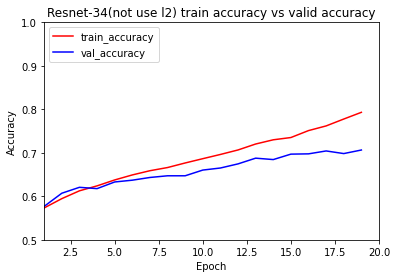

In [34]:
import matplotlib.pyplot as plt

plt.plot(history_34.history['accuracy'], 'r')
plt.plot(history_34.history['val_accuracy'], 'b')
plt.title('Resnet-34(not use l2) train accuracy vs valid accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train_accuracy', 'val_accuracy'], loc='upper left')
plt.xlim(1,20)
plt.ylim(0.5,1)
plt.show()

- loss를 보니 20epoch 동안 일정하게 감소되는 추세이다


- accuracy 그래프를 보았을때 살짝 underfitting이 된것처럼 보이는데 더 많은 epoch으로 모델이 최적으로 수렴하는걸 봤으면 좋았겠지만 나는 시간이없다

## Resnet-34 (l2_regularizer 사용)

In [35]:
cnd_model34_l2decay = build_resnet34(input_shape=(224,224,3), num_classes=2)
cnd_model34_l2decay.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stage1_conv2d (Conv2D)          (None, 112, 112, 64) 9472        input_9[0][0]                    
__________________________________________________________________________________________________
stage1_BN (BatchNormalization)  (None, 112, 112, 64) 256         stage1_conv2d[0][0]              
__________________________________________________________________________________________________
activation_288 (Activation)     (None, 112, 112, 64) 0           stage1_BN[0][0]                  
____________________________________________________________________________________________

In [36]:
'''cnd_model34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)),
    metrics=['accuracy'],
)'''

'''cnd_model34_l2decay.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)'''

cnd_model34_l2decay.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.0001, nesterov=False),
    metrics=['accuracy'],
)

'''cnd_model34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2),
    metrics=['accuracy'],
)'''


history_34_l2decay = cnd_model34_l2decay.fit(
    ds_train_batch,
    steps_per_epoch=int(18610/BATCH_SIZE),
    validation_steps=int(4652/BATCH_SIZE),
    epochs=20,
    validation_data=ds_test_batch,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
581/581 [==============================] - 89s 143ms/step - loss: 8.7296 - accuracy: 0.5216 - val_loss: 1.1640 - val_accuracy: 0.5504
Epoch 2/20
581/581 [==============================] - 83s 142ms/step - loss: 0.9014 - accuracy: 0.5542 - val_loss: 0.8908 - val_accuracy: 0.5922
Epoch 3/20
581/581 [==============================] - 82s 142ms/step - loss: 0.8604 - accuracy: 0.5826 - val_loss: 0.8563 - val_accuracy: 0.6073
Epoch 4/20
581/581 [==============================] - 82s 142ms/step - loss: 0.8354 - accuracy: 0.6200 - val_loss: 0.8275 - val_accuracy: 0.6506
Epoch 5/20
581/581 [==============================] - 83s 142ms/step - loss: 0.8051 - accuracy: 0.6551 - val_loss: 0.8103 - val_accuracy: 0.6476
Epoch 6/20
581/581 [==============================] - 82s 142ms/step - loss: 0.7823 - accuracy: 0.6780 - val_loss: 0.7928 - val_accuracy: 0.6933
Epoch 7/20
581/581 [==============================] - 83s 142ms/step - loss: 0.7525 - accuracy: 0.6995 - val_loss: 0.7716 - val_ac

In [36]:
'''cnd_model34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)),
    metrics=['accuracy'],
)'''

'''cnd_model34_l2decay.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)'''

cnd_model34_l2decay.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.0001, nesterov=False),
    metrics=['accuracy'],
)

'''cnd_model34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2),
    metrics=['accuracy'],
)'''


history_34_l2decay = cnd_model34_l2decay.fit(
    ds_train_batch,
    steps_per_epoch=int(18610/BATCH_SIZE),
    validation_steps=int(4652/BATCH_SIZE),
    epochs=20,
    validation_data=ds_test_batch,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
581/581 [==============================] - 89s 143ms/step - loss: 8.7296 - accuracy: 0.5216 - val_loss: 1.1640 - val_accuracy: 0.5504
Epoch 2/20
581/581 [==============================] - 83s 142ms/step - loss: 0.9014 - accuracy: 0.5542 - val_loss: 0.8908 - val_accuracy: 0.5922
Epoch 3/20
581/581 [==============================] - 82s 142ms/step - loss: 0.8604 - accuracy: 0.5826 - val_loss: 0.8563 - val_accuracy: 0.6073
Epoch 4/20
581/581 [==============================] - 82s 142ms/step - loss: 0.8354 - accuracy: 0.6200 - val_loss: 0.8275 - val_accuracy: 0.6506
Epoch 5/20
581/581 [==============================] - 83s 142ms/step - loss: 0.8051 - accuracy: 0.6551 - val_loss: 0.8103 - val_accuracy: 0.6476
Epoch 6/20
581/581 [==============================] - 82s 142ms/step - loss: 0.7823 - accuracy: 0.6780 - val_loss: 0.7928 - val_accuracy: 0.6933
Epoch 7/20
581/581 [==============================] - 83s 142ms/step - loss: 0.7525 - accuracy: 0.6995 - val_loss: 0.7716 - val_ac

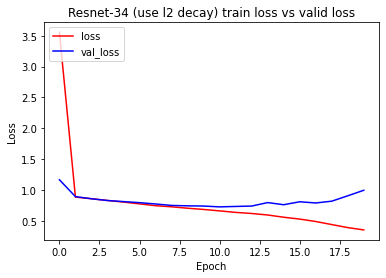

In [37]:
import matplotlib.pyplot as plt

plt.plot(history_34_l2decay.history['loss'], 'r')
plt.plot(history_34_l2decay.history['val_loss'], 'b')
plt.title('Resnet-34 (use l2 decay) train loss vs valid loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()

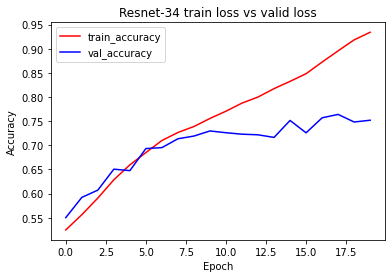

In [38]:
import matplotlib.pyplot as plt

plt.plot(history_34_l2decay.history['accuracy'], 'r')
plt.plot(history_34_l2decay.history['val_accuracy'], 'b')
plt.title('Resnet-34 train loss vs valid loss')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train_accuracy', 'val_accuracy'], loc='upper left')
plt.show()

- 아니 왜 L2 weights decay를 사용하면 오버피팅이 나는건지 도저히 이해가 가지 않는다..


- l2를 사용하지 않았을 때 적절한 최적화와 수렴을 보이고있었는데 decay를 넣어 개판이 된건가???

- decay를 너무 심하게줬나?????????


- 모델이 High variance를 가졌을때 오버피팅을 줄이기위해 regularization을 사용하는것으로 알고있는데
- 이 경우에는 노이즈를 적절하게 잡아내는 방향으로 학습이되는 모델을 regularizer를 사용하여 노이즈를 심하게 잡아서 오히려 오버피팅이 되는건가???

# Resnet-50 (L2 decay 사용)

In [39]:
cnd_model50_l2decay = build_resnet50(input_shape=(224,224,3), num_classes=2, use_l2_regularizer=True)

In [40]:
'''cnd_model50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-1,
    decay_steps=10000,
    decay_rate=0.9)),
    metrics=['accuracy'],
)'''

'''cnd_model50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)'''

cnd_model50_l2decay.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.0001, nesterov=False),
    metrics=['accuracy'],
)


'''cnd_model50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2),
    metrics=['accuracy'],
)'''

history50_l2decay = cnd_model50_l2decay.fit(
    ds_train_batch,
    steps_per_epoch=int(18610/BATCH_SIZE),
    validation_steps=int(4652/BATCH_SIZE),
    epochs=20,
    validation_data=ds_test_batch,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
581/581 [==============================] - 193s 280ms/step - loss: 29.5625 - accuracy: 0.5024 - val_loss: 1.7243 - val_accuracy: 0.5093
Epoch 2/20
581/581 [==============================] - 138s 238ms/step - loss: 1.7033 - accuracy: 0.5231 - val_loss: 1.7132 - val_accuracy: 0.5091
Epoch 3/20
581/581 [==============================] - 138s 238ms/step - loss: 1.6960 - accuracy: 0.5130 - val_loss: 1.7098 - val_accuracy: 0.4991
Epoch 4/20
581/581 [==============================] - 138s 238ms/step - loss: 1.6907 - accuracy: 0.5316 - val_loss: 1.7007 - val_accuracy: 0.5317
Epoch 5/20
581/581 [==============================] - 138s 238ms/step - loss: 1.6799 - accuracy: 0.5658 - val_loss: 1.7006 - val_accuracy: 0.5662
Epoch 6/20
581/581 [==============================] - 138s 238ms/step - loss: 1.6732 - accuracy: 0.5780 - val_loss: 1.6903 - val_accuracy: 0.5884
Epoch 7/20
581/581 [==============================] - 138s 238ms/step - loss: 1.6575 - accuracy: 0.6006 - val_loss: 1.6788 

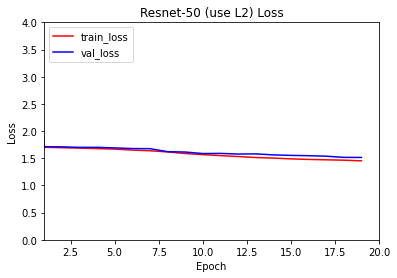

In [41]:
import matplotlib.pyplot as plt

plt.plot(history50_l2decay.history['loss'], 'r')
plt.plot(history50_l2decay.history['val_loss'], 'b')
plt.title('Resnet-50 (use L2) Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train_loss', 'val_loss'], loc='upper left')
plt.xlim(1,20)
plt.ylim(0,4)
plt.show()

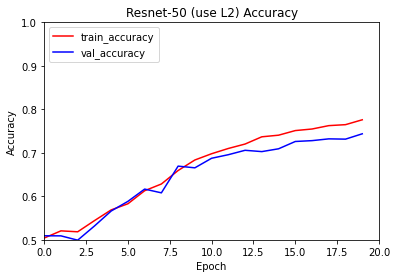

In [42]:
import matplotlib.pyplot as plt

plt.plot(history50_l2decay.history['accuracy'], 'r')
plt.plot(history50_l2decay.history['val_accuracy'], 'b')
plt.title('Resnet-50 (use L2) Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train_accuracy', 'val_accuracy'], loc='upper left')
plt.xlim(0,20)
plt.ylim(0.5,1)
plt.show()

# Resnet-50 (L2 미사용)

In [43]:
cnd_model50 = build_resnet50(input_shape=(224,224,3), num_classes=2, use_l2_regularizer=False)

In [44]:
cnd_model50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.0001, nesterov=False),
    metrics=['accuracy'],
)


history50 = cnd_model50.fit(
    ds_train_batch,
    steps_per_epoch=int(18610/BATCH_SIZE),
    validation_steps=int(4652/BATCH_SIZE),
    epochs=20,
    validation_data=ds_test_batch,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
581/581 [==============================] - 146s 241ms/step - loss: 33.2033 - accuracy: 0.5213 - val_loss: 0.8497 - val_accuracy: 0.5894
Epoch 2/20
581/581 [==============================] - 139s 239ms/step - loss: 0.8384 - accuracy: 0.6042 - val_loss: 0.8193 - val_accuracy: 0.6244
Epoch 3/20
581/581 [==============================] - 139s 238ms/step - loss: 0.8120 - accuracy: 0.6347 - val_loss: 0.8145 - val_accuracy: 0.6369
Epoch 4/20
581/581 [==============================] - 139s 239ms/step - loss: 0.7955 - accuracy: 0.6499 - val_loss: 0.8178 - val_accuracy: 0.6306
Epoch 5/20
581/581 [==============================] - 139s 239ms/step - loss: 0.7963 - accuracy: 0.6460 - val_loss: 0.8075 - val_accuracy: 0.6397
Epoch 6/20
581/581 [==============================] - 139s 239ms/step - loss: 0.7807 - accuracy: 0.6643 - val_loss: 0.7974 - val_accuracy: 0.6586
Epoch 7/20
581/581 [==============================] - 139s 239ms/step - loss: 0.7637 - accuracy: 0.6788 - val_loss: 0.7890 

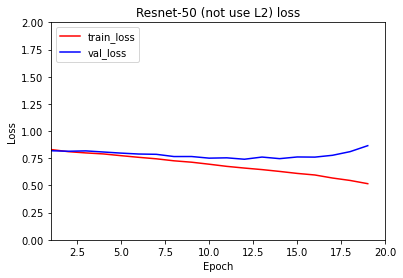

In [45]:
import matplotlib.pyplot as plt

plt.plot(history50.history['loss'], 'r')
plt.plot(history50.history['val_loss'], 'b')
plt.title('Resnet-50 (not use L2) loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train_loss', 'val_loss'], loc='upper left')
plt.xlim(1,20)
plt.ylim(0,2)
plt.show()

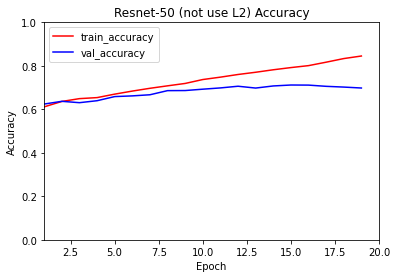

In [46]:
import matplotlib.pyplot as plt

plt.plot(history50.history['accuracy'], 'r')
plt.plot(history50.history['val_accuracy'], 'b')
plt.title('Resnet-50 (not use L2) Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train_accuracy', 'val_accuracy'], loc='upper left')
plt.xlim(1,20)
plt.ylim(0,1)
plt.show()

- resnet50 model은 l2 decay 사용 안하니 약간 오버피팅 될라는 모습을 보인다

- L2 regularizer는 모델을 50layer보다 깊게 쌓아 파라미터가 더 많아졌을때 사용하면 될듯하다 

# resnet-34 vs resnet-50

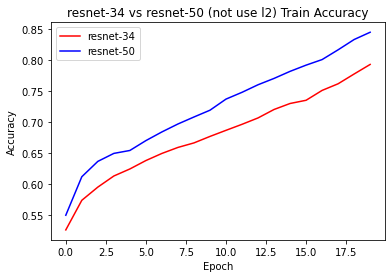

In [47]:
import matplotlib.pyplot as plt

plt.plot(history_34.history['accuracy'], 'r')
plt.plot(history50.history['accuracy'], 'b')
plt.title('resnet-34 vs resnet-50 (not use l2) Train Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet-34', 'resnet-50'], loc='upper left')
plt.show()

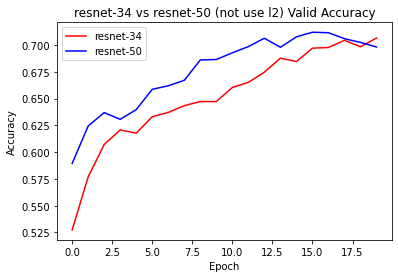

In [48]:
import matplotlib.pyplot as plt

plt.plot(history_34.history['val_accuracy'], 'r')
plt.plot(history50.history['val_accuracy'], 'b')
plt.title('resnet-34 vs resnet-50 (not use l2) Valid Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet-34', 'resnet-50'], loc='upper left')
plt.show()

- 20 epoch 근처에서 resnet34의 validation accuracy가 좋아지는 것으로보아 50이상부턴 decay를 줘야할거 같다는 확신이든다


- 또한 더 많은 epoch으로 적절한 learning rate schedule을 적용해서 학습해보면 좋겠지만 난 시간이 없다.

# Plain-50 model (not use L2)

In [49]:
cnd_plain50 = build_resnet50(input_shape=(224,224,3), not_plane=False, num_classes=2, use_l2_regularizer=False)
cnd_plain50.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
stage1_conv2d (Conv2D)       (None, 112, 112, 64)      9472      
_________________________________________________________________
stage1_BN (BatchNormalizatio (None, 112, 112, 64)      256       
_________________________________________________________________
activation_422 (Activation)  (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 56, 56, 64)        0         
_________________________________________________________________
stage2_1_conv1 (Conv2D)      (None, 56, 56, 64)        4160      
_________________________________________________________________
stage2_1_bn1 (BatchNormaliza (None, 56, 56, 64)        256

In [51]:

cnd_plain50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.0001, nesterov=False),
    metrics=['accuracy'],
)

history_plain50 = cnd_plain50.fit(
    ds_train_batch,
    steps_per_epoch=int(18610/BATCH_SIZE),
    validation_steps=int(4652/BATCH_SIZE),
    epochs=20,
    validation_data=ds_test_batch,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
581/581 [==============================] - 119s 194ms/step - loss: 23.0777 - accuracy: 0.4971 - val_loss: 14.7620 - val_accuracy: 0.4957
Epoch 2/20
581/581 [==============================] - 113s 195ms/step - loss: 14.7004 - accuracy: 0.5139 - val_loss: 14.6874 - val_accuracy: 0.4925
Epoch 3/20
581/581 [==============================] - 113s 195ms/step - loss: 14.6673 - accuracy: 0.5088 - val_loss: 14.6623 - val_accuracy: 0.4935
Epoch 4/20
581/581 [==============================] - 114s 196ms/step - loss: 14.6395 - accuracy: 0.4980 - val_loss: 14.6462 - val_accuracy: 0.4933
Epoch 5/20
581/581 [==============================] - 114s 196ms/step - loss: 14.6126 - accuracy: 0.5058 - val_loss: 14.6559 - val_accuracy: 0.4916
Epoch 6/20
581/581 [==============================] - 114s 196ms/step - loss: 14.5897 - accuracy: 0.5046 - val_loss: 14.5996 - val_accuracy: 0.4942
Epoch 7/20
581/581 [==============================] - 114s 196ms/step - loss: 14.5600 - accuracy: 0.5145 - val_l

- 겨우 20epoch 돌렸더니 학습이 되지 않는 개같은모습

# Plain-34 model (not use L2)

In [54]:
cnd_plain34 = build_resnet34(input_shape=(224,224,3), not_plane=False, num_classes=2, use_l2_regularizer=False)
cnd_plain34.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
stage1_conv2d (Conv2D)       (None, 112, 112, 64)      9472      
_________________________________________________________________
stage1_BN (BatchNormalizatio (None, 112, 112, 64)      256       
_________________________________________________________________
activation_522 (Activation)  (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 56, 56, 64)        0         
_________________________________________________________________
stage2_1_conv1 (Conv2D)      (None, 56, 56, 64)        36928     
_________________________________________________________________
stage2_1_bn1 (BatchNormaliza (None, 56, 56, 64)        256

In [55]:
cnd_plain34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.0001, nesterov=False),
    metrics=['accuracy'],
)

history_plain34 = cnd_plain34.fit(
    ds_train_batch,
    steps_per_epoch=int(18610/BATCH_SIZE),
    validation_steps=int(4652/BATCH_SIZE),
    epochs=20,
    validation_data=ds_test_batch,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
581/581 [==============================] - 78s 125ms/step - loss: 4.9120 - accuracy: 0.5039 - val_loss: 0.7442 - val_accuracy: 0.5149
Epoch 2/20
581/581 [==============================] - 72s 125ms/step - loss: 0.6982 - accuracy: 0.5031 - val_loss: 0.6975 - val_accuracy: 0.4914
Epoch 3/20
581/581 [==============================] - 73s 125ms/step - loss: 0.6940 - accuracy: 0.4990 - val_loss: 0.6942 - val_accuracy: 0.5114
Epoch 4/20
581/581 [==============================] - 73s 125ms/step - loss: 0.6936 - accuracy: 0.4967 - val_loss: 0.6964 - val_accuracy: 0.5151
Epoch 5/20
581/581 [==============================] - 73s 125ms/step - loss: 0.6935 - accuracy: 0.5026 - val_loss: 0.7005 - val_accuracy: 0.4912
Epoch 6/20
581/581 [==============================] - 73s 125ms/step - loss: 0.6933 - accuracy: 0.5006 - val_loss: 0.7002 - val_accuracy: 0.4907
Epoch 7/20
581/581 [==============================] - 73s 126ms/step - loss: 0.6929 - accuracy: 0.5065 - val_loss: 0.6938 - val_ac

- 아오 plain34 도 학습 안된다 개같은거 왜그럴까 도대체

- 오버피팅 안나기위해 224x224 image사용은 개뿔 학습조차 안되자나

- 뭐가 잘못된걸까......

# 개빡치니 씨파10에 학습시켜본다

In [65]:
def normalize_and_resize_img2(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    # image = tf.image.resize(image, [32, 32])
    return tf.cast(image, tf.float32) / 255., label

In [66]:
def apply_normalize_on_dataset2(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img2, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [67]:
BATCH_SIZE = 256
EPOCH = 20

In [68]:
(cifar_train, cifar_test), cifar_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
cifar_train_batch = apply_normalize_on_dataset(cifar_train, batch_size=BATCH_SIZE)
cifar_test_batch = apply_normalize_on_dataset(cifar_test, batch_size=BATCH_SIZE)

In [69]:
cifar_plain50 = build_resnet50(input_shape=(224,224,3), not_plane=False, num_classes=10, use_l2_regularizer=False)

In [70]:
cifar_plain50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.0001, nesterov=False),
    metrics=['accuracy'],
)

cifar_history_plain50 = cifar_plain50.fit(
    ds_train_batch,
    steps_per_epoch=int(18610/BATCH_SIZE),
    validation_steps=int(4652/BATCH_SIZE),
    epochs=20,
    validation_data=ds_test_batch,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
72/72 [==============================] - 21s 200ms/step - loss: 32.1150 - accuracy: 0.5064 - val_loss: 224.6400 - val_accuracy: 0.5208
Epoch 2/20
72/72 [==============================] - 14s 192ms/step - loss: 33.7716 - accuracy: 0.4992 - val_loss: 25.9927 - val_accuracy: 0.5226
Epoch 3/20
72/72 [==============================] - 14s 193ms/step - loss: 27.5313 - accuracy: 0.4703 - val_loss: 27.4608 - val_accuracy: 0.4896
Epoch 4/20
72/72 [==============================] - 14s 194ms/step - loss: 25.5655 - accuracy: 0.4912 - val_loss: 24.2554 - val_accuracy: 0.5312
Epoch 5/20
72/72 [==============================] - 14s 194ms/step - loss: 24.2132 - accuracy: 0.5098 - val_loss: 24.1537 - val_accuracy: 0.5295
Epoch 6/20
72/72 [==============================] - 14s 195ms/step - loss: 24.1248 - accuracy: 0.5149 - val_loss: 24.0670 - val_accuracy: 0.4653
Epoch 7/20
72/72 [==============================] - 14s 195ms/step - loss: 24.1051 - accuracy: 0.5228 - val_loss: 24.1025 - val_a

- 아오 resnet이 VGG보다 레이어 훨많으면서 파라미터는 적은데 왜 이모냥????

In [71]:
cifar_plain50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)


cifar_history_plain50 = cifar_plain50.fit(
    ds_train_batch,
    steps_per_epoch=int(18610/BATCH_SIZE),
    validation_steps=int(4652/BATCH_SIZE),
    epochs=20,
    validation_data=ds_test_batch,
    verbose=1,
    use_multiprocessing=True,
)


Epoch 1/20
72/72 [==============================] - 24s 204ms/step - loss: 23.9505 - accuracy: 0.4997 - val_loss: 23.9604 - val_accuracy: 0.4688
Epoch 2/20
72/72 [==============================] - 15s 210ms/step - loss: 23.9488 - accuracy: 0.5111 - val_loss: 23.9538 - val_accuracy: 0.5330
Epoch 3/20
72/72 [==============================] - 15s 207ms/step - loss: 23.9465 - accuracy: 0.5330 - val_loss: 23.9703 - val_accuracy: 0.4878
Epoch 4/20
72/72 [==============================] - 14s 197ms/step - loss: 23.9505 - accuracy: 0.5072 - val_loss: 23.9650 - val_accuracy: 0.4878
Epoch 5/20
72/72 [==============================] - 14s 197ms/step - loss: 23.9472 - accuracy: 0.5151 - val_loss: 23.9559 - val_accuracy: 0.4826
Epoch 6/20
72/72 [==============================] - 14s 197ms/step - loss: 23.9479 - accuracy: 0.5064 - val_loss: 23.9564 - val_accuracy: 0.4740
Epoch 7/20
72/72 [==============================] - 14s 198ms/step - loss: 23.9432 - accuracy: 0.5389 - val_loss: 23.9543 - val_ac

# plain-50 vs resnet-50

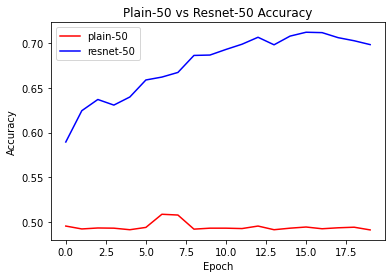

In [58]:
import matplotlib.pyplot as plt

plt.plot(history_plain50.history['val_accuracy'], 'r')
plt.plot(history50.history['val_accuracy'], 'b')
plt.title('Plain-50 vs Resnet-50 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['plain-50', 'resnet-50'], loc='upper left')
plt.show()

- plain 이 학습이 제데로 되지 않는 모습이다

- 최소한 VGG보단 모델도 깊고 파라미터도 많은데 뭔가 문제가있는 모습이다

- 지금은 못찾겠지만 추후에 문제를 찾아보려한다.

# pre-activation architecture

- 은 귀찮아서 나중에한다

- 자꾸 커널 재시작되서 다날라가서...

# 결론

- 일단 논문을 처음 구현해보았다는 것에서 많은 도움이 되었고 많은것을 얻을 수 있었다


- 논문의 모델을 구현해 보는 것 뿐만아니라 데이터셋 모델 크기 등등에 맞게 하이퍼파라미터를 조정해 볼 수 있었고 직접 무엇이 문제인지 생각해보며 여러 training 셋팅을 바꾸어가며 tuning process를 진행하여 돌려볼 수 있는 기회였다.


- 논문의 ImageNet 세팅을 디폴트로 변경해나가며 진행했지만 아직 경험이 많이 없고 리소스의 한계로 적절한 tuning process를 진행하지 못한것 같다.


- 추후에는 더 많은 실험을 해보고싶다.

[resnet version2 (약간 다른 구조)](https://github.com/KangTae123/aiffel/blob/master/resnet_V2.ipynb)